# Hierarchical Modeling 

For a better `class` definition see [pymc3 example](https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/probabilistic_matrix_factorization.html).

For a tutorial on Hierarchical check out these tutorials from the `pymc3` examples page: 
  - https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM-simpsons-paradox.html
  - https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/rugby_analytics.html
  
For more background about hierarchical Modeling, see these tutorials: 
  - https://twiecki.io/blog/2014/03/17/bayesian-glms-3/
  - https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/
  
  
Right now, each posterior predicted per glacier is independent of one another. This isn't the most efficient, nor the most bayesian. We should implement something that's properly hierarchical, but that will mean some reparameterization: 
  - https://stackoverflow.com/questions/48184335/userwarning-pymc3-what-does-reparameterize-mean


In terms of better priors, see: 
  - [Rounce et al. 2020](https://www-cambridge-org.proxy.lib.sfu.ca/core/services/aop-cambridge-core/content/view/61D8956E9A6C27CC1A5AEBFCDADC0432/S0022143019000911a.pdf/quantifying_parameter_uncertainty_in_a_largescale_glacier_evolution_model_using_bayesian_inference_application_to_high_mountain_asia.pdf): _Quantifying parameter uncertainty in a large-scale glacier evolution model using Bayesian
inference: application to High Mountain Asia_

In [1]:
import theano
from theano import pp
import theano.tensor as tt

import glob
import time 
import pymc3 as pm 
import numpy as np
import arviz as az
import pandas as pd
import xarray as xr
import scipy.stats as st
import matplotlib.pyplot as plt 


import PDD

In [2]:
Young2020 = xr.open_dataset("../MB_tune/notebooks/Young_etal_2020_Delta_T_-0.9_C.nc")
z_ref  = Young2020.stack(z=('x', 'y')).Elevation.mean().values
A_mean = Young2020.stack(z=('x', 'y')).Accumulation.mean().values

In [3]:
const =  dict(T_m    = 0.0, 
              T_rs   = 1.0,
              A_mean = 1.4 * 910., 
              α      = 10.5, 
              T_ma   = -6.65,
              ΔTΔz   = 6.5E-3, 
              T_p    = 196, 
              ref_z  = 2193)

melt_model = PDD.PDD_melt_model(**const)

In [4]:
glacs = [('lilk-a',   '00.1'), 
         ('crmpt18-a','00.2'), 
         ('crmpt12',   -0.3)]

results_fp = "../../initialization/coarse/result/{}/nc/{}_*_{}_OFF*.nc"



dfs = []
for glac in glacs: 
    key, offset = glac
    
    src_fp = glob.glob(results_fp.format(*[key] * 2, offset))[0]
    
    with xr.open_dataset(src_fp) as src: 
        # correct for minimum ice thickness
        src["depth"] = xr.where(src.depth <= 10, 0, src.depth)
        # apply sigma coordinate transform for vertical coordinate
        src["Z"]     = src.zbed + src.Z * src.height 
        # Calculate the magnitude of the velocity vectors
        src['vel_m'] = np.sqrt(src['velocity 1']**2 + src['velocity 2']**2)    
        
    # Exract data of interest from NetCDF file
    z  = src['zs'].isel(t=-1,coord_2=-1).values[np.newaxis, :]
    MB = np.random.normal(src['zs accumulation flux 2'].isel(t=-1,coord_2=-1).values, 1e-1)[np.newaxis, :]
        
    dfs.append(pd.DataFrame({f'z':z[0], "MB": MB[0], 'key':[key]*len(z[0])}))
        
Elmer_Runs = pd.concat(dfs, ignore_index=True)
Elmer_Runs["key_factor"] =  pd.factorize(Elmer_Runs.key)[0]

coords = {"key": Elmer_Runs.key.unique(),
          "idx": np.arange(Elmer_Runs.shape[0])}


## Part 2: Independent Predictions for each Glacier

In [5]:
# Define "data", which allows hierarchical prediction
with pm.Model(coords=coords) as model: 
    # constant model encapsulated within pandas df
    MB = pm.Data("MB", Elmer_Runs["MB"], dims="idx")
    z  = pm.Data("z",  Elmer_Runs["z"],  dims="idx")
    g  = pm.Data("g",  Elmer_Runs["key_factor"],  dims="idx")
    
# Define Priors
with model: 
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----> Mass balance Model (physical priors)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    #---------------------------
    # -> global model parameters
    #---------------------------
    # Somewhat base of Aschwanden et al. 2019
    C_prior = pm.TruncatedNormal("C",      mu=2.0,  sigma=1.5,  lower=1)
    # Need a reference for the accumulation grad distibution 
    grad_a  = pm.Uniform("grad_a", lower=1e-4, upper=1e-2)
    
    #-------------------------------------
    # -> glacier-specific model parameters
    #-------------------------------------
    # Degree Day factor: Braithwaite (2008) / Rounce et al. 2020
    f_s_prior = pm.TruncatedNormal("f_s",    mu=4.1,  sigma=0.5,  lower=0.0, dims='key')
    # Somewhat base of Aschwanden et al. 2019
    f_r_prior = pm.TruncatedNormal('f_r',    mu=0.5,  sigma=0.5,  lower=0.0, upper=1, dims='key')


    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # We should probably account for the error associated with our 
    # mass balance model not able to actually fit the Young et al. results
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ????? 
    
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----> Hyperparameters (likelihood related priors)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    sigma = pm.HalfCauchy("sigma", 10, )    



with model: 
    mu = pm.Deterministic('mu', 
                          melt_model.tt_forward(z, f_s_prior[g], C_prior, grad_a, f_r_prior[g]), 
                          dims='idx')
    
# Define likelihood (function?)  
with model: 
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=MB, dims='idx')
    
# run inference: Sample   
with model: 
    
    prior = pm.sample_prior_predictive()
    
    # obtain starting values via MAP
    # startvals = pm.find_MAP()
    
    trace = pm.sample(draws=500, 
                      tune=1000, 
                      cores=2, 
                      return_inferencedata=True,
                      target_accept=0.99);


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, f_r, f_s, grad_a, C]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 271 seconds.
The number of effective samples is smaller than 25% for some parameters.


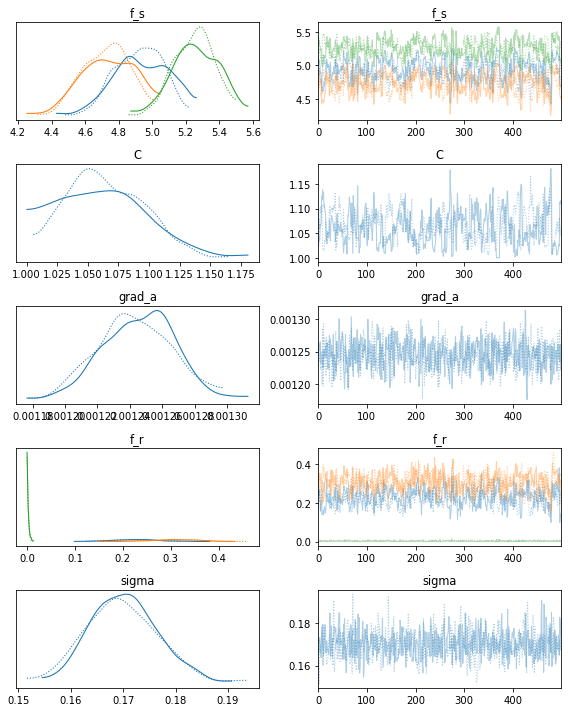

In [6]:
az.plot_trace(trace, 
              var_names=["f_s", "C", "grad_a", "f_r", "sigma"],
              figsize=(8,10));
plt.tight_layout()

In [7]:
# ax = az.plot_pair(
#     trace,
#     var_names=["f_s", "C", "grad_a", "f_r", "sigma"],
#     kind=["scatter", "kde"],
#     kde_kwargs={"fill_last": False},
#     marginals=True,
#     point_estimate="median",
#     figsize=(10, 8),
# )

In [8]:
pm.summary(trace).head(n=9)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
C,1.063,0.033,1.000,1.115,0.002,0.002,212.0,280.0,1.03
grad_a,0.001,0.000,0.001,0.001,0.000,0.000,808.0,759.0,1.00
f_s[lilk-a],4.928,0.152,4.691,5.228,0.010,0.007,213.0,276.0,1.03
f_s[crmpt18-a],4.732,0.147,4.464,4.985,0.010,0.007,227.0,371.0,1.02
f_s[crmpt12],5.255,0.126,5.032,5.490,0.008,0.006,223.0,364.0,1.02
f_r[lilk-a],0.225,0.044,0.139,0.303,0.003,0.002,280.0,448.0,1.00
f_r[crmpt18-a],0.308,0.048,0.213,0.387,0.003,0.002,351.0,432.0,1.00
f_r[crmpt12],0.002,0.002,0.000,0.006,0.000,0.000,554.0,384.0,1.00
sigma,0.170,0.007,0.159,0.183,0.000,0.000,798.0,498.0,1.00


In [9]:
with model: 
    ppc = pm.sample_posterior_predictive(
    trace, var_names=["f_s", "C", "grad_a", "f_r", "sigma", "Y_obs"])

# post_samples = np.stack([ppc[key] for key in list(ppc)[:-1]])

In [10]:
samples = [ppc[key] for key in list(ppc)[:-1]]

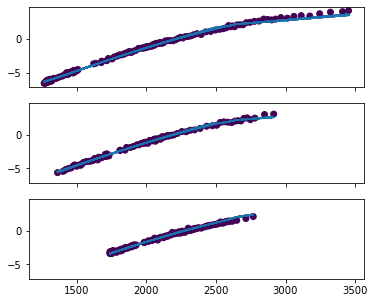

In [11]:
fig, ax = plt.subplots(3,1, figsize=(6,5),
                       sharex=True, sharey=True)

for j in [0,1,2]:
    sub_df = Elmer_Runs[Elmer_Runs['key_factor']==j]
    
    for i in np.random.randint(0,999,499):
        params = []
                
        for key in list(ppc)[:-2]: 
            if len(ppc[key].shape) == 2: 
                params.append(ppc[key][i, j])
            else: 
                params.append(ppc[key][i])
        
        ax[j].plot(sub_df.z.values, 
                   melt_model.eval_forward(sub_df.z.values, *params, parts=False), 
                   c='tab:blue', 
                   alpha=0.1)
        
    ax[j].scatter(sub_df.z, sub_df.MB, c=sub_df.key_factor)

    


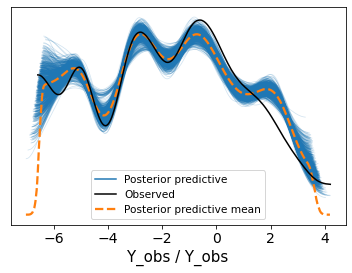

In [12]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model));

## Part 3: Hierarchical Modeling 

From [Braithwaite 2008](https://www-cambridge-org.proxy.lib.sfu.ca/core/services/aop-cambridge-core/content/view/6C2362F61B7DE7F153247A039736D54C/S0022143000207636a.pdf/temperature-and-precipitation-climate-at-the-equilibrium-line-altitude-of-glaciers-expressed-by-the-degree-day-factor-for-melting-snow.pdf) we have sense of the prior distribution for the degree day factor for snow. Now the challenge for the hierarchical modeling is to find a way to minic said distibution as a "parent population" and model the deviation from that parent population for each glacier. 

In [15]:
# Define "data", which allows hierarchical prediction
with pm.Model(coords=coords) as model: 
    # constant model encapsulated within pandas df
    MB = pm.Data("MB", Elmer_Runs["MB"], dims="idx")
    z  = pm.Data("z",  Elmer_Runs["z"],  dims="idx")
    g  = pm.Data("g",  Elmer_Runs["key_factor"],  dims="idx")
    
# Define Priors
with model: 
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----> Mass balance Model (physical priors)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    #---------------------------
    # -> global model parameters
    #---------------------------
    # Somewhat base of Aschwanden et al. 2019
    C_prior = pm.TruncatedNormal("C",      mu=2.0,  sigma=1.5,  lower=1)
    # Need a reference for the accumulation grad distibution 
    grad_a  = pm.Uniform("grad_a", lower=1e-4, upper=1e-2)
    f_r_prior  = pm.TruncatedNormal('f_r',    mu=0.5,  sigma=0.5,  lower=0.0, upper=1)

    #----------------------------------------
    # -> hyperpriors (i.e. parent population)
    #----------------------------------------
    f_s_sigma  = pm.HalfCauchy('f_s_sigma', 1)
    f_s_mu     = pm.TruncatedNormal("f_s_mu", 4.1, sigma = 0.5, lower=0.0)
    
    f_r_sigma  = pm.HalfCauchy('f_r_sigma', 0.5)
    f_r_mu     = pm.TruncatedNormal("f_r_mu", 0.5, sigma = 0.25, lower=0.0)
    
    #-------------------------------------
    # -> glacier-specific model parameters
    #-------------------------------------
    # Degree Day factor: Braithwaite (2008) / Rounce et al. 2020
    f_s_offset = pm.Normal('f_s_offset', mu=0, sd=1, dims='key')
    f_s_prior  = pm.Deterministic("f_s", f_s_mu + f_s_offset * f_s_sigma)    
    
    
    # Somewhat base of Aschwanden et al. 2019
    f_r_offset = pm.Normal('f_r_offset', mu=0, sd=0.5, dims='key')
    f_r_prior  = pm.Deterministic("f_r", f_r_mu + f_r_offset * f_r_sigma) 


    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # We should probably account for the error associated with our 
    # mass balance model not able to actually fit the Young et al. results
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ????? 
    
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----> Hyperparameters (likelihood related priors)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    sigma = pm.HalfCauchy("sigma", 10, )    



with model: 
    mu = pm.Deterministic('mu', 
                          melt_model.tt_forward(z, f_s_prior[g], C_prior, grad_a, f_r_prior[g]), 
                          dims='idx')
    
# Define likelihood (function?)  
with model: 
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=MB, dims='idx')
    
# run inference: Sample   
with model: 
    
    # prior = pm.sample_prior_predictive()
    
    # obtain starting values via MAP
    # startvals = pm.find_MAP()
    
    trace = pm.sample(draws=500, 
                      tune=1000, 
                      cores=2, 
                      return_inferencedata=True, 
                      target_accept=0.99);


KeyboardInterrupt: 

In [ ]:
az.plot_trace(trace,
              figsize=(8,10));
plt.tight_layout()